# Urban POMDP

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, Parameters, GridInterpolations
using AutomotiveDrivingModels,AutoViz
using Reel 

In [2]:
include("AutomotivePOMDPs.jl")
using AutomotivePOMDPs

(Any...) in module Base at util.jl:532 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.

In [3]:
rng = MersenneTwister(1);

...) in module Base at util.jl:585 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.

In [4]:
params = UrbanParams()
env = UrbanEnv(params=params)
obs_dist = ObstacleDistribution(env)
pomdp = UrbanPOMDP(env=env, obs_dist=obs_dist, max_cars=0., max_peds=1, ped_birth=0.5)

Array{Float64, 1

AutomotivePOMDPs.UrbanPOMDP
  env: AutomotivePOMDPs.UrbanEnv
  obs_dist: AutomotivePOMDPs.ObstacleDistribution
  sensor: AutomotiveDrivingModels.LidarSensor
  models: Dict{Int64,AutomotiveDrivingModels.DriverModel}
  ego_type: AutomotiveDrivingModels.VehicleDef
  car_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  max_cars: Int64 0
  max_peds: Int64 1
  max_entities: Int64 10
  max_acc: Float64 2.0
  ego_start: Float64 7.0
  ego_goal: AutomotiveDrivingModels.LaneTag
  off_grid: Vec.VecSE2
  ΔT: Float64 0.5
  car_birth: Float64 0.3
  ped_birth: Float64 0.5
  a_noise: Float64 1.0
  v_noise: Float64 1.0
  pos_obs_noise: Float64 0.5
  vel_obs_noise: Float64 0.5
  collision_cost: Float64 -1.0
  action_cost: Float64 0.0
  goal_reward: Float64 1.0
  γ: Float64 0.95


}, AutomotiveDrivingModels.LatLonAccel

In [5]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

mutable struct AccelPolicy <: Policy
    problem::UrbanPOMDP
end
policy = AccelPolicy(pomdp)
function POMDPs.action(policy::AccelPolicy, b::Void)
    return actions(policy.problem)[4]
end

) in module AutomotiveDrivingModels at C:\Users\Maxime\.julia\v0.6\AutomotiveDrivingModels\src\2d\actions\lat_lon_accel.jl:13 overwritten in module AutoUrban at C:\Users\Maxime\.julia\v0.6\AutoUrban\src\simulation\actions.jl:10.

In [6]:
hr = HistoryRecorder(rng=rng, max_steps=100)
@time hist = simulate(hr, pomdp, policy, up);

.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64

 2.493922 seconds (1.06 M allocations: 55.691 MiB, 0.66% gc time)


}}, 1}, Any) in module AutomotivePOMDPs at C:\Users\Maxime\OneDrive - Leland Stanford Junior University\Research\admscenarios\utils/rendering.jl:21 overwritten at C:\Users\Maxime\OneDrive - Leland Stanford Junior University\Research\admscenarios\utils/rendering.jl:32.

In [7]:
duration, fps, render_hist = animate_scenes(hist.state_hist, pomdp.env, overlays = SceneOverlay[IDOverlay()], sim_dt=pomdp.ΔT)
speed_factor = 2.
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Int64}}, 1}, Any) in module AutomotivePOMDPs overwritten.


Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_2525.tmp", 0x000000000000000f, 4.0, nothing)

In [8]:
?discounted_reward

search: discounted_reward undiscounted_reward



No documentation found.

`POMDPToolbox.discounted_reward` is a `Function`.

```
# 1 method for generic function "discounted_reward":
discounted_reward(h::POMDPToolbox.SimHistory) in POMDPToolbox at C:\Users\Maxime\.julia\v0.6\POMDPToolbox\src\simulators/history.jl:75
```


In [10]:
# Fast evaluation
probs = 0.:0.1:1.0
crash_array = zeros(length(probs))
for (j,prob) in enumerate(probs)
    pomdp.ped_birth = prob
    n_eval = 1000
    crashes, time_outs, successes = 0, 0, 0
#     sim = RolloutSimulator(rng=rng, max_steps=100)
    for i=1:n_eval
        hr = HistoryRecorder(rng=rng, max_steps=100)
        hist = simulate(hr, pomdp, policy, up)
        r_tot = discounted_reward(hist)
        if r_tot < 0.
            crashes += 1
        elseif r_tot == 0.
            time_outs += 1
            return
        else 
            successes += 1
        end
    end
    crash_array[j] = crashes
    println("Crashes : ", crashes/10, " Successes ", successes/10, " Time outs ", time_outs/10)
end

Crashes : 0.0 Successes 100.0 Time outs 0.0
Crashes : 1.9 Successes 98.1 Time outs 0.0
Crashes : 3.3 Successes 96.7 Time outs 0.0
Crashes : 3.5 Successes 96.5 Time outs 0.0
Crashes : 7.1 Successes 92.9 Time outs 0.0
Crashes : 6.9 Successes 93.1 Time outs 0.0
Crashes : 8.1 Successes 91.9 Time outs 0.0
Crashes : 10.8 Successes 89.2 Time outs 0.0
Crashes : 12.6 Successes 87.4 Time outs 0.0
Crashes : 13.4 Successes 86.6 Time outs 0.0
Crashes : 15.0 Successes 85.0 Time outs 0.0


In [9]:
lane = rand(rng, get_lanes(pomdp.env.roadway))
route = random_route(rng, pomdp.env.roadway, lane)
for l in route
    println(l.tag)
end

LaneTag(20, 1)
LaneTag(5, 1)


In [16]:
conflict_lanes = get_conflict_lanes(pomdp.env.crosswalks[3], pomdp.env.roadway)
for l in conflict_lanes
    println(l.tag)
end

LaneTag(5, 1)
LaneTag(6, 1)


In [ ]:
intersect(conflict_lanes, route)

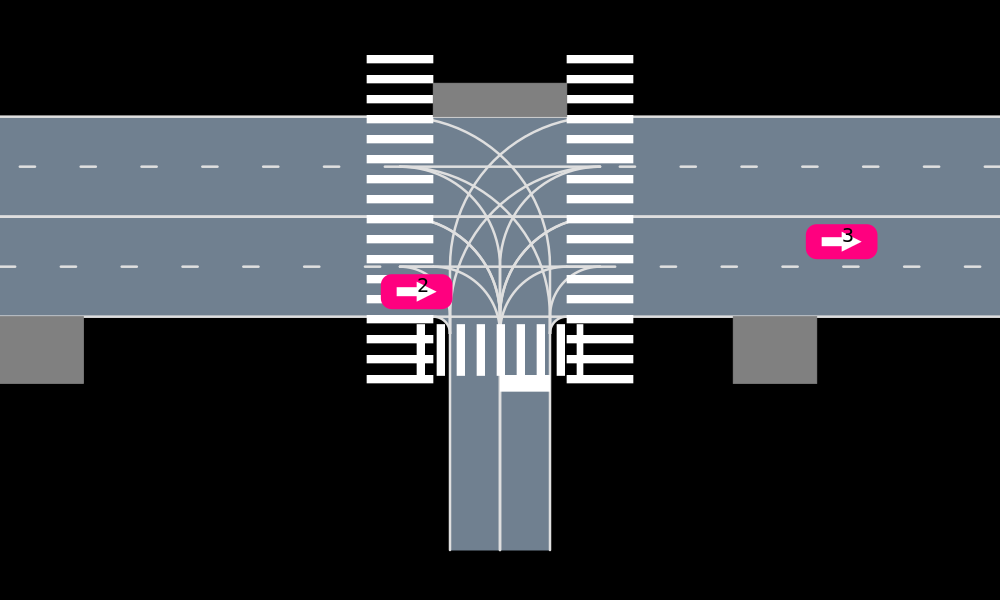

In [8]:
AutoViz.render(initial_state(pomdp, rng, true), env, [IDOverlay()], cam=FitToContentCamera(0.))

In [20]:
n_steps = 100
scenes = Scene[]
pomdp.ped_birth = 0.5
s = initial_state(pomdp, rng)
push!(scenes, s)
for step=1:n_steps
    sp = generate_s(pomdp, s, UrbanAction(0.), rng)
    s = sp
    push!(scenes, s)
end

In [21]:
duration, fps, render_hist = animate_scenes(scenes, pomdp.env, overlays = SceneOverlay[IDOverlay()], sim_dt=pomdp.ΔT)
speed_factor = 2.
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_9211.tmp", 0x0000000000000065, 4.0, nothing)

In [18]:
pomdp.models[7].intersection_driver

AutomotivePOMDPs.IntersectionDriver
  a: AutomotivePOMDPs.LonAccelDirection
  navigator: AutomotivePOMDPs.RouteFollowingIDM
  intersection: Array{AutomotiveDrivingModels.Lane}((2,))
  intersection_entrances: Array{AutomotiveDrivingModels.Lane}((5,))
  intersection_exits: Array{AutomotiveDrivingModels.Lane}((8,))
  horizon: Float64 20.0
  stop_delta: Float64 4.0
  accel_tol: Float64 0.0
  have_wait_list: Bool false
  wait_list: Array{Int64}((2,)) [9, 11]
  priority: Bool false
  stop: Bool true
  n_yield: Int64 2


In [15]:
function initial_pedestrian(pomdp::UrbanPOMDP, scene::Scene, rng::AbstractRNG, first_scene::Bool = false)
    env = pomdp.env
    crosswalk_pos = env.params.crosswalk_pos

    # position along the crosswalk
    t0 = rand(rng, Uniform(-env.params.crosswalk_width/2, env.params.crosswalk_width/2))
    s0 = rand(rng, [0., get_end(env.crosswalk)])
    ϕ0 = float(π)
    if s0 == 0.
        ϕ0 = 0.
    end
    if first_scene
        s0 = rand(rng, Uniform(0., get_end(env.crosswalk)))
    end

    #velocity
    v0 = rand(rng, Uniform(0., env.params.ped_max_speed))
    posF = Frenet(env.crosswalk, s0, t0, ϕ0)

    ped_initial_state = VehicleState(posF, env.roadway, v0);

    # new id, increment last id
    max_id = 0
    for veh in scene
        if veh.id > max_id
            max_id = veh.id
        end
    end
    id = max_id + 1
    if max_id == 0
        id = 2
    end


    return Vehicle(ped_initial_state, AutomotivePOMDPs.PEDESTRIAN_DEF, id)
end

initial_pedestrian (generic function with 2 methods)

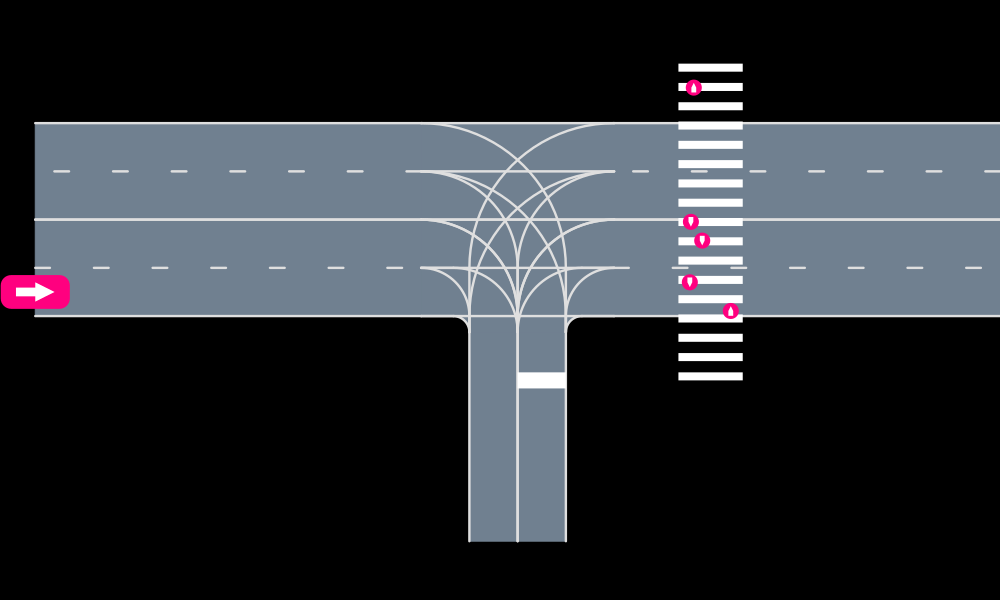

In [33]:
scene = Scene()
models = Dict{Int, DriverModel}()
for i=1:5
    ped = initial_pedestrian(pomdp, scene, rng, true)
    push!(scene, ped)
    models[ped.id] = ConstantPedestrian()
end
# car = initial_car(pomdp, scene, rng)
# collision point 7.0, 4.5
car = Vehicle(VehicleState(Frenet(env.roadway[LaneTag(3,1)], 0.), env.roadway, 6.), VehicleDef(), 1)
push!(scene, car);
AutoViz.render(scene, env, cam=FitToContentCamera(0.))

In [34]:
timestep = 0.5

lane = get_lane(pomdp.env.roadway, car)
route = random_route(rng, pomdp.env.roadway, lane)
intersection_entrances = get_start_lanes(pomdp.env.roadway)
if !(route[1] ∈ intersection_entrances)
    intersection = Lane[]
    intersection_exits = Lane[]
else
    intersection_exits = get_exit_lanes(pomdp.env.roadway)
    intersection=Lane[route[1], route[2]]
end
navigator = RouteFollowingIDM(route=route)
intersection_driver = IntersectionDriver(navigator= navigator,
#                                                        intersection=intersection,
                                                       intersection_entrances = intersection_entrances,
                                                       intersection_exits = intersection_exits,
                                                       stop_delta=0.,
                                                       accel_tol=0.)
cw_conflict_lanes = get_conflict_lanes(pomdp.env.crosswalk, pomdp.env.roadway)
crosswalk_driver = CrosswalkDriver(navigator = navigator,
                                   crosswalk = pomdp.env.crosswalk,
                                   conflict_lanes = cw_conflict_lanes,
                                   intersection_entrances = intersection_entrances,
                                   yield=!isempty(intersect(cw_conflict_lanes, route)),
                                   debug=true)
models[car.id] = UrbanDriver(navigator=navigator,
                        intersection_driver=intersection_driver,
                       crosswalk_driver=crosswalk_driver,
                            debug=true           )

nticks = 50
rec = SceneRecord(nticks+1, timestep)
@time simulate!(rec, scene, pomdp.env.roadway, models, nticks)

ID 1 priority false stop false a 2.0 wait list [2, 3, 4, 6] dist_to_cw 23.5
inter 2.0
crosswalk 2.0
ID 1 priority false stop false a 2.0 wait list [2, 3, 4, 6] dist_to_cw 20.25
inter 2.0
crosswalk 2.0
ID 1 priority false stop false a 1.0 wait list [2, 3, 4, 6] dist_to_cw 16.5
inter 1.0
crosswalk 1.0
ID 1 priority false stop false a 0.5 wait list [2, 3, 4, 6] dist_to_cw 12.375
inter 0.5
crosswalk 0.5
ID 1 priority false stop false a 0.25 wait list [2, 3, 6] dist_to_cw 8.0625
inter 0.25
crosswalk 0.25
ID 1 priority false stop false a 0.125 wait list [2, 3, 6] dist_to_cw 3.65625
inter 0.125
crosswalk 0.125
ID 1 priority false stop false a 0.0625 wait list [2, 3, 6] dist_to_cw 0.0
inter 0.0625
crosswalk 0.0625
ID 1 priority false stop false a 0.03125 wait list [2, 3, 6] dist_to_cw 0.0
inter 0.03125
crosswalk 0.03125
ID 1 priority false stop false a 0.015625 wait list [2, 3, 6] dist_to_cw 0.0
inter 0.015625
crosswalk 0.015625
ID 1 priority false stop false a 0.0078125 wait list [2, 3, 6] di

SceneRecord(nscenes=51)

In [35]:
cam = FitToContentCamera(0.)
duration, fps, render_rec = animate_record(pomdp.env, rec, sim_dt=timestep, overlays = SceneOverlay[IDOverlay()])
film = roll(render_rec, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpUti1ns", 0x0000000000000033, 2.0, nothing)

In [6]:
scene = initial_state(pomdp, rng)
AutoViz.render(scene, env, [IDOverlay()], cam=FitToContentCamera(0.))

LoadError: [91mMethodError: no method matching AutomotivePOMDPs.CrosswalkDriver(; navigator=AutomotivePOMDPs.RouteFollowingIDM
  route: Array{AutomotiveDrivingModels.Lane}((2,))
  dir: Int64 1
  a: Float64 NaN
  σ: Float64 NaN
  k_spd: Float64 1.0
  δ: Float64 4.0
  T: Float64 1.5
  v_des: Float64 9.0
  s_min: Float64 5.0
  a_max: Float64 2.0
  d_cmf: Float64 2.0
  d_max: Float64 9.0
, crosswalk=AutomotiveDrivingModels.Lane(LaneTag(25, 1), AutomotiveDrivingModels.CurvePt[CurvePt({12.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({12.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 4.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), intersect=AutomotiveDrivingModels.Lane(LaneTag(7, 1), AutomotiveDrivingModels.CurvePt[CurvePt({6.000, 4.500, 3.142}, 0.000, 0.000, 0.000), CurvePt({-6.000, 4.500, 3.142}, 12.000, 0.000, 0.000)], 3.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:solid, :white), AutomotiveDrivingModels.LaneBoundary(:solid, :white), AutomotiveDrivingModels.LaneConnection[LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {2, 1})], AutomotiveDrivingModels.LaneConnection[LaneConnection(U, CurveIndex(1, 0.000), RoadIndex({1, 1.000000}, {1, 1})]))[0m
Closest candidates are:
  AutomotivePOMDPs.CrosswalkDriver(; a, navigator, crosswalk, conflict_lanes, ped_model, ped_start, stop_delta, accel_tol, d_tol, yield, priority, stop, wait_list, clear, debug) at /home/boutonm/.julia/v0.6/Parameters/src/Parameters.jl:379[91m got unsupported keyword argument "intersect"[39m
  AutomotivePOMDPs.CrosswalkDriver([91m::AutomotivePOMDPs.CrosswalkDriver[39m; kws...) at /home/boutonm/.julia/v0.6/Parameters/src/Parameters.jl:443
  AutomotivePOMDPs.CrosswalkDriver([91m::AutomotivePOMDPs.CrosswalkDriver[39m, [91m::Associative[39m) at /home/boutonm/.julia/v0.6/Parameters/src/Parameters.jl:446[91m got unsupported keyword arguments "navigator", "crosswalk", "intersect"[39m
  ...[39m

In [8]:
function lane_to_segment(lane::Lane, roadway::Roadway)
    # only works for straight lanes
    lane_a = get_posG(Frenet(lane, 0.), roadway)
    lane_b = get_posG(Frenet(lane, get_end(lane)), roadway)
    return LineSegment(lane_a, lane_b)
end

function  get_conflict_lanes(crosswalk::Lane, roadway::Roadway)
    # find lane intersecting with crosswalk 
    cw_seg = lane_to_segment(crosswalk, roadway)    
    conflict_lanes = Lane[]
    lanes = get_lanes(roadway)
    for lane in lanes
        lane_seg = lane_to_segment(lane, roadway)
        if intersects(lane_seg, cw_seg) && !(lane ∈ conflict_lanes)
            push!(conflict_lanes, lane)
        end
    end
    return conflict_lanes
end

# return +1 if going toward, -1 if going away
function direction_from_center(ped::Vehicle, crosswalk::Lane)
    s_ped = ped.state.posF.s
    Δs = get_end(crosswalk)/2 - s_ped
    return sign(Δs*cos(ped.state.posF.ϕ))
end

function is_crossing(ped::Vehicle, crosswalk::Lane, conflict_lanes::Vector{Lane})
    # check if the pedestrian is in the conflict zone
    for lane in conflict_lanes
        ped_f = Frenet(ped.state.posG, lane, roadway)
        if abs(ped_f.t) < lane.width/2
            return true
        end
    end
    # at this point, the pedestrian is not on the road
    # check if she is going to cross or not
    if direction_from_center(ped, crosswalk) > 0.
        return true
    end
    return false
end

is_crossing (generic function with 1 method)

In [10]:
# given crosswalk compute the "conflict zone"
crosswalk = env.crosswalk
conflict_lanes = get_conflict_lanes(crosswalk, env.roadway)

ped = scene[findfirst(scene, 5)]
is_crossing(ped, crosswalk, conflict_lanes)

LoadError: [91mUndefVarError: scene not defined[39m

In [ ]:
function get_stop_zone(crosswalk::Lane, roadway::Roadway)
end

In [31]:
length(conflict_lanes)

4

In [28]:
lane_seg = lane_to_segment(lanes[3], roadway)

Vec.LineSegment(VecE2(12.000, -10.000), VecE2(12.000, 10.000))

In [12]:
methods(get_posG)

# 1 method for generic function "get_posG":
get_posG(frenet::AutomotiveDrivingModels.Frenet, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:27

In [9]:
roadway = env.roadway
veh = scene[findfirst(scene, 8)]
lane = get_lane(roadway, veh)

AutomotiveDrivingModels.Lane(LaneTag(25, 1), AutomotiveDrivingModels.CurvePt[CurvePt({12.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({12.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 4.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[])

In [27]:
methods(Frenet)

# 10 methods for generic function "(::Type)":
AutomotiveDrivingModels.Frenet(roadind::AutomotiveDrivingModels.RoadIndex, s::Float64, t::Float64, ϕ::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:2
AutomotiveDrivingModels.Frenet(roadind::AutomotiveDrivingModels.RoadIndex, roadway::AutomotiveDrivingModels.Roadway; t, ϕ) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:8
AutomotiveDrivingModels.Frenet(roadproj::AutomotiveDrivingModels.RoadProjection, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:13
AutomotiveDrivingModels.Frenet(lane::AutomotiveDrivingModels.Lane, s::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:20
AutomotiveDrivingModels.Frenet(lane::AutomotiveDrivingModels.Lane, s::Float64, t::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:20
AutomotiveDrivingModels.Frenet(lane::AutomotiveDrivingModels.Lane, s::Float64, t::Float64, ϕ::Float64) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:20
AutomotiveDrivingModels.Frenet(posG::Vec.VecSE2, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:23
AutomotiveDrivingModels.Frenet(posG::Vec.VecSE2, lane::AutomotiveDrivingModels.Lane, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:24
AutomotiveDrivingModels.Frenet(roadind, s, t, ϕ) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/frenet.jl:2
(::Type{T})(arg) where T in Base at sysimg.jl:24

In [ ]:
function is_in_lane(veh::Vehicle, lane::Lane, roadway::Roadway)
    pos_g = veh.state.posG
    proj(pos_g, lane)
end

In [12]:
methods(proj)

# 8 methods for generic function "proj":
proj(posG::Vec.VecSE2, curve::Array{AutomotiveDrivingModels.CurvePt,1}) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/curves.jl:222
proj(posG::Vec.VecSE2, lane::AutomotiveDrivingModels.Lane, roadway::AutomotiveDrivingModels.Roadway; move_along_curves) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/roadways.jl:367
proj(posG::Vec.VecSE2, seg::AutomotiveDrivingModels.RoadSegment, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/roadways.jl:421
proj(posG::Vec.VecSE2, roadway::AutomotiveDrivingModels.Roadway) in AutomotiveDrivingModels at /home/boutonm/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/roadways.jl:444
proj(a::Vec.VecE2, b::Vec.VecE2, ::Type{Float64}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE2.jl:74
proj(a::Vec.VecE2, b::Vec.VecE2, ::Type{Vec.VecE2}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE2.jl:77
proj(a::Vec.VecE3, b::Vec.VecE3, ::Type{Float64}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE3.jl:74
proj(a::Vec.VecE3, b::Vec.VecE3, ::Type{Vec.VecE3}) in Vec at /home/boutonm/.julia/v0.6/Vec/src/vecE3.jl:77

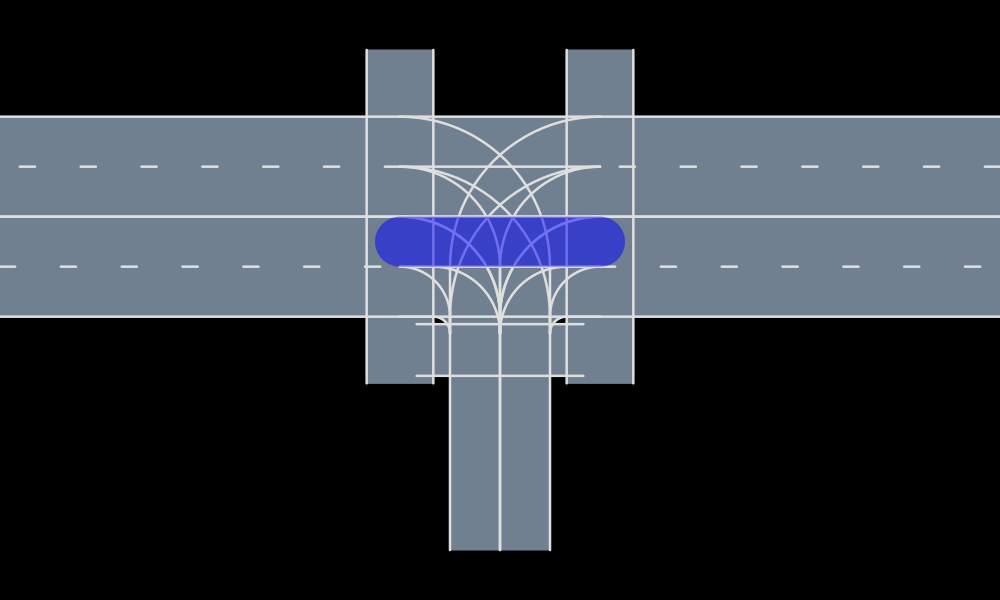

In [15]:
using Interact

scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

# @manipulate for i in 1 : length(env.roadway.segments)
#     AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))
# end

i=8
AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))

In [10]:
env.roadway[LaneTag(1,1)].exits

2-element Array{AutomotiveDrivingModels.LaneConnection,1}:
 LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {9, 1})
 LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {7, 1})

In [ ]:
function is_straight(lane::Lane)
end